In [1]:
# Recurrent Neural Network

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the training set
dataset_train = pd.read_csv('./marketdata/soybean/zsk20_daily_price-history-10-25-2019.csv')
#dataset_train = dataset_train[dataset_train["Volume"] != 0]

dataset_train.Time = pd.to_datetime(dataset_train.Time.str.replace('D', 'T'))
dataset_train = dataset_train.sort_values('Time')
dataset_train.set_index('Time', inplace=True)
dataset_train.shape

(490, 7)

In [2]:
dataset_train.head()

,Open,High,Low,Last,Change,Volume,Open Int
Time,,,,,,,
2017-11-15,985.0,985.0,985.0,985.0,6.5,0,0
2017-11-16,991.0,991.0,991.0,991.0,6.0,0,0
2017-11-17,1004.5,1004.5,1004.5,1004.5,13.5,0,0
2017-11-20,1006.5,1006.5,1006.5,1006.5,2.0,0,0
2017-11-21,1006.0,1006.0,1006.0,1006.0,-0.5,0,0


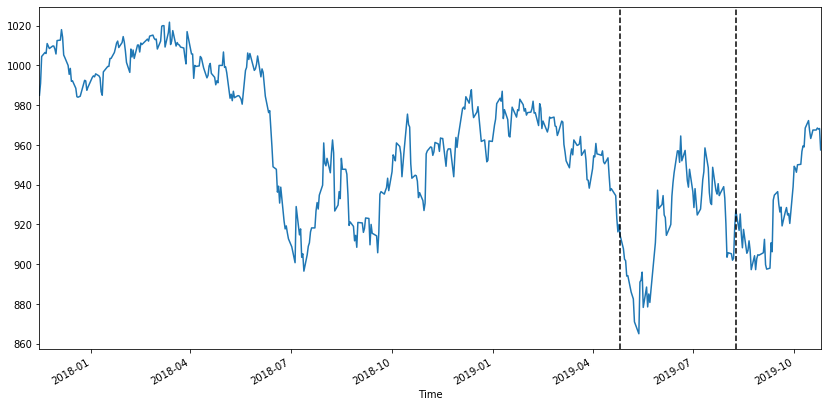

In [3]:
ax = dataset_train["Last"].plot(figsize=(14, 7))
ax.axvline("26-04-2019", linestyle="--", c="black")
ax.axvline("08-09-2019", linestyle="--", c="black")

In [4]:
# Feature Scaling
training_set = dataset_train.iloc[:, 1:7].values

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (-1, 1))
training_set_scaled = sc.fit_transform(training_set)

In [5]:
# Creating a data structure with 15 timesteps and 1 output - we use last 15 prices to predict next. 
#This takes data from 15th row onwards
X_whole = []
y_whole = []

X_whole_vchange = []
y_whole_vchange = []


X_whole_wvap = []
y_whole_wvap = []

sequence_size = 1
for i in range(sequence_size, len(training_set_scaled)):
    X_whole = np.append(X_whole, training_set_scaled[i-sequence_size:i, 2])
    #X_whole = np.append(X_whole, training_set_scaled[i, 6])
    #X_whole = np.append(X_whole, training_set_scaled[i, 7])
    vwap = 0
    vol = 0
    vchg = 0
    for j in range(sequence_size):
        if (j+i<training_set_scaled.shape[0]):
            vwap += (((np.sum(training_set_scaled[j+i, 0:3]))/3) * training_set_scaled[j+i, 4])
            vchg += (((training_set_scaled[j+i, 3])) * training_set_scaled[j+i, 4])
            vol += training_set_scaled[j+i, 4]
    #if vwap !=0  and vol != 0:
    X_whole = np.append(X_whole, vwap/vol)
    X_whole = np.append(X_whole, vchg/vol)
    y_whole.append(training_set_scaled[i, 2])

sz = training_set_scaled.shape[0]-sequence_size
X_whole, y_whole = np.array(X_whole.reshape(sz,sequence_size+2)), np.array(y_whole)


for i in range(sequence_size, len(X_whole)):
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i-sequence_size:i, sequence_size])
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i, 0])
    X_whole_wvap = np.append(X_whole_wvap,X_whole[i, sequence_size+1])
    y_whole_wvap.append(X_whole[i, sequence_size])
    
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i-sequence_size:i, sequence_size+1])
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i, 0])
    X_whole_vchange = np.append(X_whole_vchange,X_whole[i, sequence_size])
    y_whole_vchange.append(X_whole[i, sequence_size+1])

sz1 = X_whole.shape[0]-sequence_size
X_whole_wvap, y_whole_wvap = np.array(X_whole_wvap.reshape(sz1,sequence_size+2)), np.array(y_whole_wvap)
X_whole_vchange, y_whole_vchange = np.array(X_whole_vchange.reshape(sz1,sequence_size+2)), np.array(y_whole_vchange)

In [6]:
#print(X_whole_wvap)
#print(y_whole_wvap)

In [7]:
#Train -valid and Test split in time order
X_train = X_whole[0:362,:].copy()
X_valid = X_whole[362:420,:].copy()
X_test = X_whole[420:,:].copy()

y_train = y_whole[0:362].copy()
y_valid = y_whole[362:420].copy()
y_test = y_whole[420:].copy()


X_train_wvap = X_whole_wvap[0:362,:].copy()
X_valid_wvap = X_whole_wvap[362:420,:].copy()
X_test_wvap = X_whole_wvap[420:,:].copy()

y_train_wvap = y_whole_wvap[0:362].copy()
y_valid_wvap = y_whole_wvap[362:420].copy()
y_test_wvap = y_whole_wvap[420:].copy()

X_train_vchange = X_whole_vchange[0:362,:].copy()
X_valid_vchange = X_whole_vchange[362:420,:].copy()
X_test_vchange = X_whole_vchange[420:,:].copy()

y_train_vchange = y_whole_vchange[0:362].copy()
y_valid_vchange = y_whole_vchange[362:420].copy()
y_test_vchange = y_whole_vchange[420:].copy()

In [8]:
# Reshaping
X_train_vchange = np.reshape(X_train_vchange, (X_train_vchange.shape[0], X_train_vchange.shape[1], 1))
X_valid_vchange = np.reshape(X_valid_vchange, (X_valid_vchange.shape[0], X_valid_vchange.shape[1], 1))

In [9]:
%%time
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Initialising the RNN
regressorVchange = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_vchange.shape[1], 1)))
regressorVchange.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50, return_sequences = True))
regressorVchange.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50, return_sequences = True))
regressorVchange.add(Dropout(0.2))

#regressorVchange.add(LSTM(units = 50, return_sequences = True))
#regressorVchange.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressorVchange.add(LSTM(units = 50))
regressorVchange.add(Dropout(0.2))

# Adding the output layer
regressorVchange.add(Dense(units = 1))

from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# Compiling the RNN
regressorVchange.compile(optimizer = adm, loss = 'mean_squared_error' , metrics=["mean_squared_error"])

# Fitting the RNN to the Training set
hist = regressorVchange.fit(X_train_vchange, y_train_vchange, validation_data=(X_valid_vchange, y_valid_vchange), epochs = 1500, batch_size = 64, verbose=0)

Using TensorFlow backend.


Wall time: 1min 17s


Saved model to disk
dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


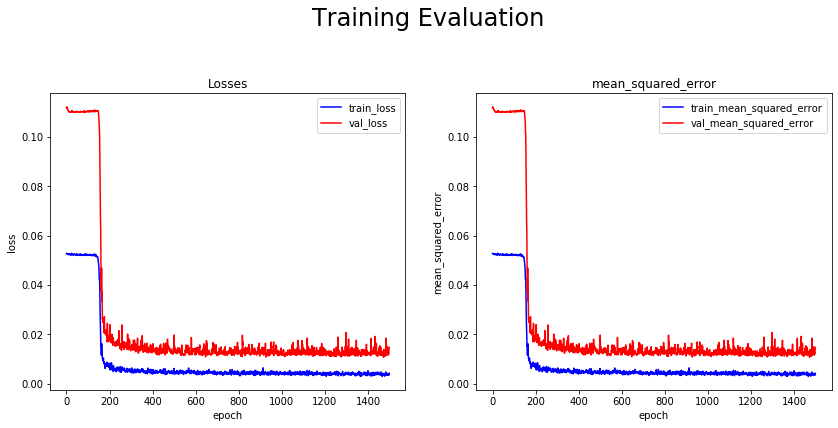

In [10]:
regressorVchange.save_weights("zsk20_1000epoch_Rsqr93_vchange.h5")
print("Saved model to disk")
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

plt.figure(figsize=(14,12))
plt.suptitle('Training Evaluation', fontsize=24)

plt.subplot(2,2,1)
#Plotting Training history
print(hist.history.keys())

# Visualising the results
plt.plot(hist.history['loss'], color = 'blue',  label = 'train_loss')
plt.plot(hist.history['val_loss'], color = 'red',  label = 'val_loss')
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
#plt.show()
plt.subplot(2,2,2)
# Visualising the results
plt.plot(hist.history['mean_squared_error'], color = 'blue',  label = 'train_mean_squared_error')
plt.plot(hist.history['val_mean_squared_error'], color = 'red',  label = 'val_mean_squared_error')
plt.title('mean_squared_error')
plt.xlabel('epoch')
plt.ylabel('mean_squared_error')
plt.legend()
plt.show()

sqrt mean_squared_error:  0.06956967737615667
mean_squared_error:  0.004839940010222526
mean_absolute_error:  0.05433763707392486


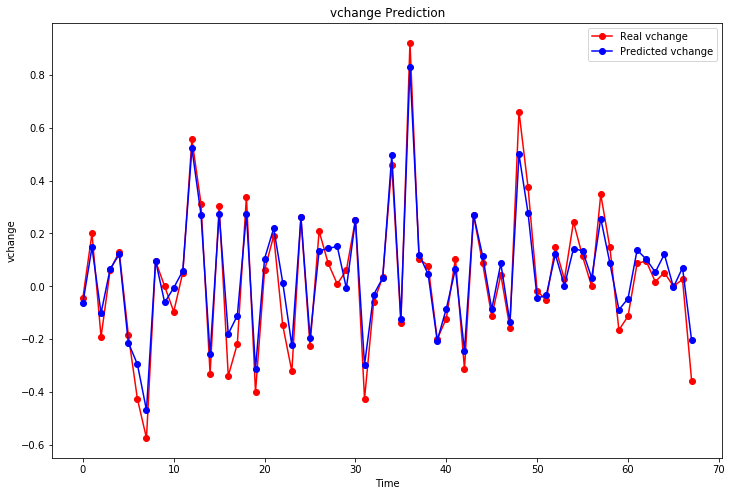

In [11]:
# Part 3 - Making the predictions and visualising the results
#real_stock_price = sc.inverse_transform(y_test.reshape(-1, 1))
X_test_vchange = np.reshape(X_test_vchange, (X_test_vchange.shape[0], X_test_vchange.shape[1], 1))
predicted_vchange = regressorVchange.predict(X_test_vchange)
# create empty table with 6 fields to inverse

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(y_test_vchange, predicted_vchange)))
print("mean_squared_error: ", mean_squared_error(y_test_vchange, predicted_vchange))
mean_absolute_error = mean_absolute_error(y_test_vchange, predicted_vchange)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(y_test_vchange, color = 'red',  marker='o', label = 'Real vchange')
plt.plot(predicted_vchange, color = 'blue',  marker='o', label = 'Predicted vchange')
plt.title('vchange Prediction')
plt.xlabel('Time')
plt.ylabel('vchange')
plt.legend()
plt.show()

In [12]:
#real_stock_price, predicted_stock_price
y_test_vchange = y_test_vchange.reshape(-1,1)
SS_Residual = sum((y_test_vchange-predicted_vchange.reshape(-1,1))**2)
SS_Total = sum((y_test_vchange-np.mean(y_test_vchange))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test_vchange)-1)/(len(y_test_vchange)-X_train_vchange.shape[1]-1)
print ("R Squared:", r_squared, "\nAdjusted R Squared:", adjusted_r_squared)

R Squared: [0.92898318] 
Adjusted R Squared: [0.92565427]


[20:30:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7673984140864136 0.4734213766611307
0.1894397012729178
sqrt mean_squared_error:  0.1894397012729178
mean_squared_error:  0.03588740041837233
mean_absolute_error:  0.13857705675808668


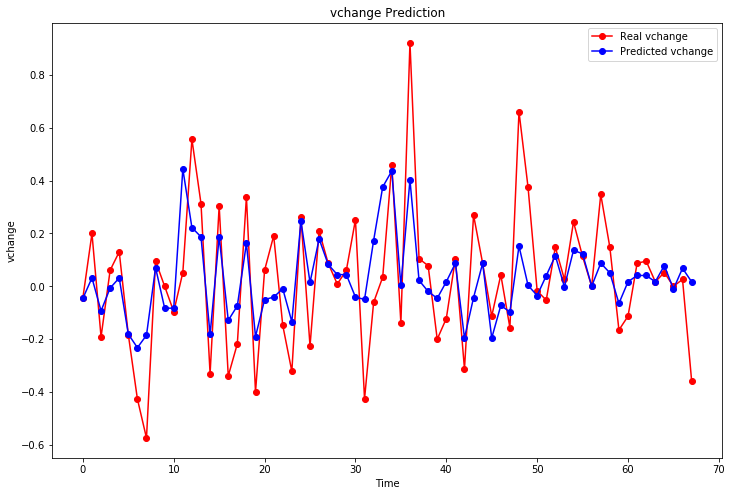

In [13]:
X_train_vchange = X_whole_vchange[0:362,:].copy()
X_valid_vchange = X_whole_vchange[362:420,:].copy()
X_test_vchange = X_whole_vchange[420:,:].copy()

y_train_vchange = y_whole_vchange[0:362].copy()
y_valid_vchange = y_whole_vchange[362:420].copy()
y_test_vchange = y_whole_vchange[420:].copy()
from sklearn.metrics import mean_squared_error as MSE
from xgboost.sklearn import XGBRegressor
reg=XGBRegressor(learning_rate=0.1, n_estimators=60, n_jobs=1)
reg.fit(X_train_vchange, y_train_vchange)
print(reg.score(X_train_vchange, y_train_vchange), reg.score(X_test_vchange, y_test_vchange))
print(np.sqrt(MSE(y_test_vchange, reg.predict(X_test_vchange))))
predicted_stock_price = reg.predict(X_test_vchange)

predicted_vchange = reg.predict(X_test_vchange)
# create empty table with 6 fields to inverse

from sklearn.metrics import mean_absolute_error
from math import sqrt
# report performance
from sklearn.metrics import mean_squared_error
print("sqrt mean_squared_error: ", sqrt(mean_squared_error(y_test_vchange, predicted_vchange)))
print("mean_squared_error: ", mean_squared_error(y_test_vchange, predicted_vchange))
mean_absolute_error = mean_absolute_error(y_test_vchange, predicted_vchange)
print("mean_absolute_error: ", mean_absolute_error)

fig = plt.figure(figsize=(12,8))
# Visualising the results
plt.plot(y_test_vchange, color = 'red',  marker='o', label = 'Real vchange')
plt.plot(predicted_vchange, color = 'blue',  marker='o', label = 'Predicted vchange')
plt.title('vchange Prediction')
plt.xlabel('Time')
plt.ylabel('vchange')
plt.legend()
plt.show()